# Model Explanation

## Dataset & Model Loading

In [1]:
import pandas as pd
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display

df_train = pd.read_csv("../dataset/training_set.csv")
X_text = df_train["text"]
y_binary = df_train["multiclass_label"]

df_voc = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()

label2id = {label: idx for idx, label in enumerate(sorted(df_voc["multiclass_label"].unique()))}

df_test = pd.read_csv("../dataset/test_set.csv")

X_text = df_train["text"]
y_binary = df_test["multiclass_label"]

df_filtered = df_test[df_test["multiclass_label"] != "not_cyberbullying"].copy()
df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)
X_text_pruned = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

tfidf_vectorizer = joblib.load("../model/tfidf_vocabulary_multiclass.pkl")

X_test_tfidf = tfidf_vectorizer.transform(X_text_pruned)

file_name = f"../model/grid_search_multiclass/RandomForest_TF-IDF_multiclass.pkl"
clf = joblib.load(file_name)

print(type(clf))

print(clf.steps)

# from <class 'sklearn.pipeline.Pipeline'> extract <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
rf_model = clf.named_steps["model"] 

print(type(rf_model))

<class 'sklearn.pipeline.Pipeline'>
[('model', RandomForestClassifier(n_estimators=500, random_state=42))]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


## Random Example Selection

In [2]:
random.seed(42) # for reproducibility
np.random.seed(42)

y_pred = rf_model.predict(X_test_tfidf)

true_labels = y_multiclass.to_numpy()
correct_examples = {}

for label in np.unique(true_labels):
    indices = np.where((y_pred == label) & (true_labels == label))[0]
    if len(indices) > 0:
        correct_examples[label] = random.choice(indices)  

data = []
for label_id, index in correct_examples.items():
    label_name = [k for k, v in label2id.items() if v == label_id][0]
    text = X_text_pruned.iloc[index]
    data.append({
        "label_id": label_id,
        "label_name": label_name,
        "text": text,
        "original_index": index
    })

df_correct_examples = pd.DataFrame(data)

print(df_correct_examples)

df_correct_examples.to_csv("../dataset/selected_explanable_example.csv", index=False)

   label_id           label_name  \
0         0                  age   
1         1            ethnicity   
2         2               gender   
3         3  other_cyberbullying   
4         4             religion   

                                                text  original_index  
0  ive bulli life look grow high school realli hi...            6576  
1                  worst fucj video fuck dumb nigger            1108  
2  rt dont ed im stupid girl eat lot wonder shes ...             389  
3     sheesh river littl bulli poor fray felinedrama            3482  
4  dont know real radic christian friend dont sup...            2555  


## Local Model Explanation

In [3]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")
indices = df_correct_examples["original_index"].tolist()

X_example_tfidf = X_test_tfidf[indices].toarray().astype("float32")
feature_names = tfidf_vectorizer.get_feature_names_out()

for i in range(len(indices)):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": feature_names[j],
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)


=== TreeInterpreter Explanation ===
True class: 0 (age)
Predicted class: 0
Text preview: ive bulli life look grow high school realli hit hard bc inlov boy didnt realli say anyth mean made feel love want left differ girl differ time...

Bias (expected value): 0.2024
Prediction (probabilities): [0.99  0.008 0.    0.    0.002]


,feature,contribution,tfidf_value
259,school,0.217343,0.107051
124,high,0.186055,0.125641
37,bulli,0.167958,0.102128
102,girl,0.146252,0.126143
206,nigger,0.007141,0.000000
16,anyth,-0.006852,0.185651
36,boy,0.004890,0.211079
195,muslim,0.004741,0.000000
149,joke,0.004677,0.000000
70,dumb,0.004617,0.000000



=== TreeInterpreter Explanation ===
True class: 1 (ethnicity)
Predicted class: 1
Text preview: worst fucj video fuck dumb nigger...

Bias (expected value): 0.2016
Prediction (probabilities): [0.    0.992 0.006 0.002 0.   ]


,feature,contribution,tfidf_value
206,nigger,0.327156,0.396804
70,dumb,0.266350,0.402132
96,fuck,0.160773,0.367792
259,school,0.014300,0.000000
20,ass,-0.013234,0.000000
37,bulli,0.012946,0.000000
33,black,-0.007832,0.000000
319,video,-0.007429,0.738624
243,rape,0.006334,0.000000
124,high,0.005799,0.000000



=== TreeInterpreter Explanation ===
True class: 2 (gender)
Predicted class: 2
Text preview: rt dont ed im stupid girl eat lot wonder shes fuck fat...

Bias (expected value): 0.2012
Prediction (probabilities): [0.036 0.034 0.687 0.243 0.   ]


,feature,contribution,tfidf_value
102,girl,0.208520,0.237136
253,rt,0.160357,0.268131
37,bulli,0.061663,0.000000
96,fuck,-0.058080,0.213788
265,sexist,-0.048147,0.000000
137,im,0.038369,0.262223
206,nigger,0.037627,0.000000
70,dumb,0.035227,0.000000
259,school,0.031662,0.000000
100,gay,-0.027974,0.000000



=== TreeInterpreter Explanation ===
True class: 3 (other_cyberbullying)
Predicted class: 3
Text preview: sheesh river littl bulli poor fray felinedrama...

Bias (expected value): 0.1922
Prediction (probabilities): [1.16284732e-01 4.00000000e-03 7.21526535e-05 8.79643115e-01
 0.00000000e+00]


,feature,contribution,tfidf_value
259,school,0.303701,0.000000
168,littl,-0.084453,0.909781
37,bulli,0.043803,0.415088
102,girl,0.041142,0.000000
124,high,0.037772,0.000000
195,muslim,0.021301,0.000000
206,nigger,0.016827,0.000000
70,dumb,0.013270,0.000000
243,rape,0.013077,0.000000
149,joke,0.012874,0.000000



=== TreeInterpreter Explanation ===
True class: 4 (religion)
Predicted class: 4
Text preview: dont know real radic christian friend dont support way great state alabama want know pledg loyalti extremist group want kill american...

Bias (expected value): 0.2025
Prediction (probabilities): [0.    0.    0.012 0.026 0.962]


,feature,contribution,tfidf_value
45,christian,0.278276,0.189345
242,radic,0.270488,0.217140
287,support,0.144905,0.202221
153,kill,0.035211,0.216749
195,muslim,-0.034927,0.000000
323,want,-0.018160,0.391641
134,idiot,-0.017825,0.000000
37,bulli,0.017727,0.000000
142,islam,-0.017089,0.000000
259,school,0.016410,0.000000


## Global Model Explanation

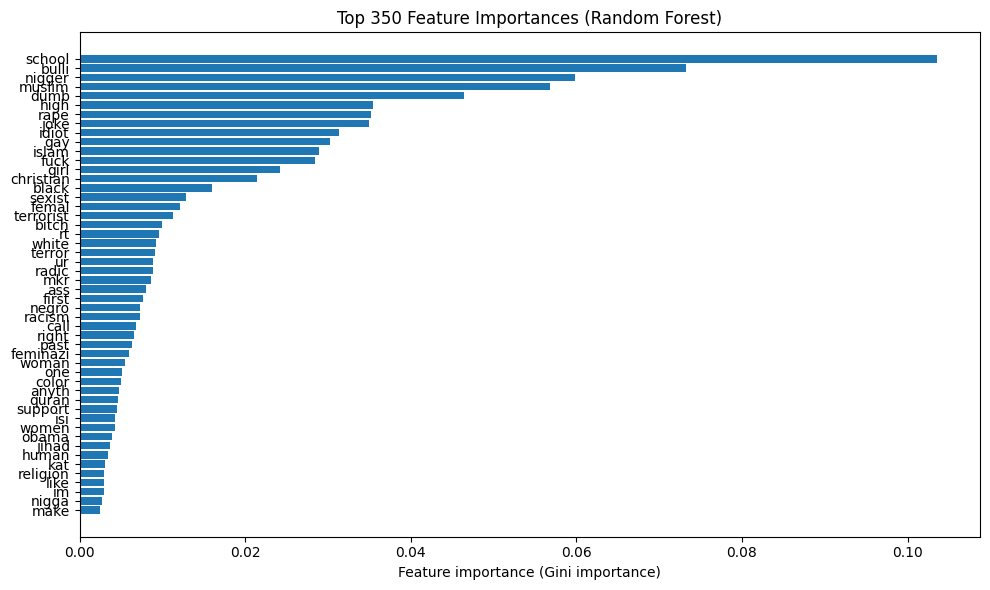

In [4]:
importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 350 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


